In [53]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


### Week 9

0.041458330436527344 std of coefficients
0.035249777307518826 mean bse


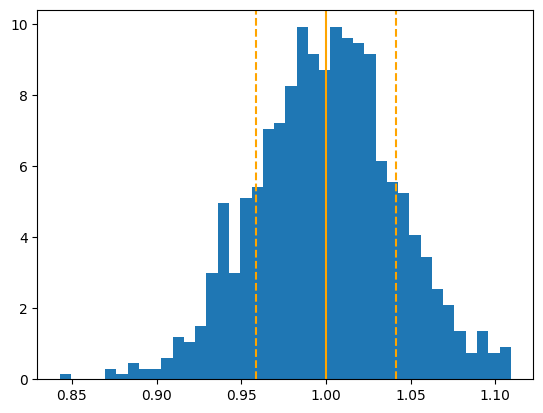

In [5]:
# 1. Write some code that will use a simulation to estimate the standard deviation of the coefficient when there is heteroskedasticity.  
# Compare these standard errors to those found via statsmodels OLS or a similar linear regression model.

def compute_standard_error(true_effect, var_x, var_resid, sample_size, n_sims = 1000, random_seed = 0):
    np.random.seed(random_seed)

    params_list = list()
    bse_list = list()
    for _ in range(n_sims):
        X = np.random.normal(0, np.sqrt(var_x), sample_size)
        Y = true_effect * X + np.random.normal(0, np.abs(0.5 * X + 1), sample_size)
        df = sm.add_constant(pd.DataFrame({"X": X})) 
        results = sm.OLS(Y, df).fit()
        params_list.append(results.params.X)
        bse_list.append(results.bse.X)
    print(np.std(params_list), "std of coefficients")
    print(np.mean(bse_list), "mean bse")

    plt.hist(params_list, density = True, bins = 40)
    plt.axvline(true_effect, color = 'orange')
    plt.axvline(true_effect + np.std(params_list), color = 'orange', label = '+1 SE', linestyle = '--')
    plt.axvline(true_effect - np.std(params_list), color = 'orange', label = '-1 SE', linestyle = '--')

compute_standard_error(1, 1, 1, 1000, n_sims = 1000, random_seed = 1)

In [ ]:
# 2. Write some code that will use a simulation to estimate the standard deviation of the coefficient when errors are highly correlated / non-independent.
# Compare these standard errors to those found via statsmodels OlS or a similar linear regression model.

def coef_std_corr(n_sims):
    param_list = list()
    bse_list = list()
    np.random.seed(0)
    for n in range(n_sims):
        num = 10000
        X = np.random.normal(0, 5, num)
        epsilon = X + np.random.normal(0, 5, num)
        Y = 2 * X + epsilon
        df = pd.DataFrame({"X": X, "Y": Y})
        results = sm.OLS(Y, sm.add_constant(df["X"])).fit()
        param_list.append(results.params.X)
        bse_list.append(results.bse.X)
    print(f"Simulation STD: {np.std(param_list)}")
    print(f"OLS BSE: {np.mean(bse_list)}")
    # return param_list, bse_list

coef_std_corr(1000)

Simulation STD: 0.010392885893848675
OLS BSE: 0.010000444977868242


In [12]:
# Show that if the correlation between coefficients is high enough, then the estimated standard deviation of the coefficient, using bootstrap errors, 
# might not match that found by a full simulation of the Data Generating Process.  (This can be fixed if you have a huge amount of data for the bootstrap simulation.)
def coef_std_highcorr(n_sims):
    param_list = list()
    bse_list = list()
    np.random.seed(0)
    for n in range(n_sims):
        num = 1000
        X = np.random.normal(0, 1, num)
        errors = np.random.normal(0, 1, num)
        correlated_errors = np.zeros(num)
        rho = 0.9 # High correlation
        correlated_errors[0] = errors[0]
        for i in range(1, num):
            correlated_errors[i] = rho * correlated_errors[i-1] + errors[i]
        Y = 2 * X + correlated_errors
        df = pd.DataFrame({"X": X, "Y": Y})
        results = sm.OLS(Y, sm.add_constant(df["X"])).fit()
        param_list.append(results.params.X)
        bse_list.append(results.bse.X)
    print(f"Simulation STD: {np.std(param_list)}")
    print(f"OLS BSE: {np.mean(bse_list)}")
    # return param_list, bse_list

coef_std_highcorr(100)

Simulation STD: 0.069241415493508
OLS BSE: 0.07071709378702522


### Week 10

In [ ]:
# We are skipping this one, this time.

### Week 11

           Y  Time
0  12.738734     0
1  21.250085     1
2  17.325587     2
3   9.470189     3
4  12.283370     4
            Y  Time
95  43.592287    95
96  27.549228    96
97  20.155534    97
98  38.752968    98
99  27.000107    99


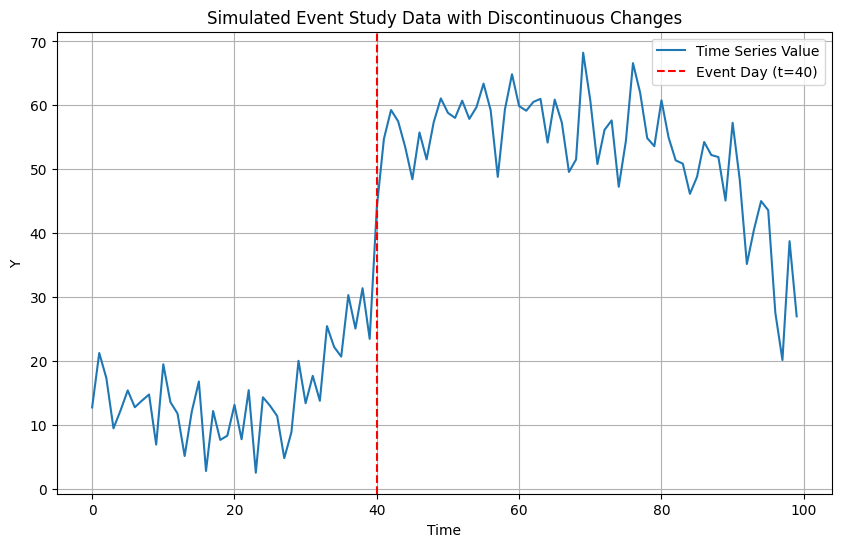

In [ ]:
# 1. Construct a dataset for an event study where the value, derivative, and second derivative of a trend all change discontinuously (suddenly) after an event.

def generate_discont_data(num_days, event_time):
    time = np.arange(num_days)
    # Days relative to the event
    days_relative = time - event_time
    
    b_before = 30.0
    slope_before = 1.5
    acc_before = 0.03
    b_delta = 20.0
    slope_delta = -0.6
    acc_delta = -0.05

    value = np.zeros(num_days)
    
    for i, t in enumerate(days_relative):
        if t < 0:
            value[i] = b_before + slope_before * t + acc_before * t**2
        else:
            value[i] = (b_before + b_delta) + (slope_before + slope_delta) * t + (acc_before + acc_delta) * t**2

    noise = np.random.normal(0, 5.0, num_days)
    value += noise
    
    df = pd.DataFrame({'Y': value, 'Time': time})
    return df

num_days = 100
event_time = 40
df = generate_discont_data(num_days, event_time)

print(df.head())
print(df.tail())

plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Y'], label='Time Series Value')
plt.axvline(x=40, color='r', linestyle='--', label='Event Day (t=40)')
plt.title('Simulated Event Study Data with Discontinuous Changes')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()



In [28]:
# Build a model that tries to decide whether the event is real (has a nonzero effect) using:
# (a) only the value,
df['post_event'] = (df['Time'] >= event_time).astype(int)

X = sm.add_constant(df['post_event'])
Y = df['Y']

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     495.7
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           4.07e-40
Time:                        06:57:58   Log-Likelihood:                -354.50
No. Observations:                 100   AIC:                             713.0
Df Residuals:                      98   BIC:                             718.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5295      1.339     10.853      0.0

In [29]:
# (b) the value, derivative, and second derivative.
# Which of these models is better at detecting and/or quantifying the impact of the event?  (What might "better" mean here?)
df['first_derivative'] = np.gradient(df['Y'])
df['second_derivative'] = np.gradient(df['first_derivative'])

X = sm.add_constant(df[['post_event', 'first_derivative', 'second_derivative']])
Y = df['Y']

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     184.8
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           9.53e-40
Time:                        07:03:11   Log-Likelihood:                -348.91
No. Observations:                 100   AIC:                             705.8
Df Residuals:                      96   BIC:                             716.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                14.3552      1.28

           Y  Time Group  Y1  Y2  Y3
0   7.829746     0    Y1   1   0   0
1   3.605479     1    Y1   1   0   0
2   7.935794     2    Y1   1   0   0
3  14.161255     3    Y1   1   0   0
4  -4.827863     4    Y1   1   0   0
              Y  Time Group  Y1  Y2  Y3
295  101.273087    95    Y3   0   0   1
296  110.301285    96    Y3   0   0   1
297   99.991186    97    Y3   0   0   1
298   96.422119    98    Y3   0   0   1
299   96.399516    99    Y3   0   0   1


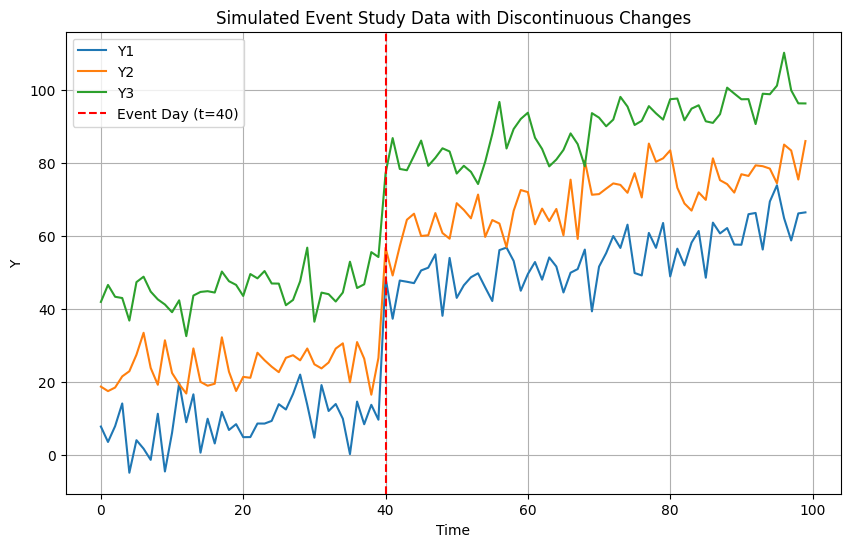

In [51]:
# 2. Construct a dataset in which there are three groups whose values each increase discontinuously (suddenly) by the same amount at a shared event; they change in parallel
# over time, but they have different starting values. 

def generate_parallel_data(num_days, event_time):
    time = np.arange(num_days)
    # Days relative to the event
    days_relative = time - event_time
    
    b_1 = 15
    b_2 = 30
    b_3 = 50

    slope = 0.3
    acc = 0.001

    jump = 30

    value_1 = np.zeros(num_days)
    value_2 = np.zeros(num_days)
    value_3 = np.zeros(num_days)

    
    for i, t in enumerate(days_relative):
        if t < 0:
            value_1[i] = b_1 + slope * t + acc * t**2
            value_2[i] = b_2 + slope * t + acc * t**2
            value_3[i] = b_3 + slope * t + acc * t**2
        else:
            value_1[i] = b_1 + jump + slope * t + acc * t**2
            value_2[i] = b_2 + jump + slope * t + acc * t**2
            value_3[i] = b_3 + jump + slope * t + acc * t**2

    noise_1 = np.random.normal(0, 5.0, num_days)
    noise_2 = np.random.normal(0, 5.0, num_days)
    noise_3 = np.random.normal(0, 5.0, num_days)

    value_1 += noise_1
    value_2 += noise_2
    value_3 += noise_3
    
    df_1 = pd.DataFrame({'Y': value_1, 'Time': time, 'Group': 'Y1'})
    df_2 = pd.DataFrame({'Y': value_2, 'Time': time, 'Group': 'Y2'})
    df_3 = pd.DataFrame({'Y': value_3, 'Time': time, 'Group': 'Y3'})

    combined_df = pd.concat([df_1, df_2, df_3], ignore_index=True)
    group_dummies = pd.get_dummies(combined_df['Group'], prefix_sep="", dtype=int)
    df = pd.concat([combined_df, group_dummies], axis=1)
    return df

num_days = 100
event_time = 40
df = generate_parallel_data(num_days, event_time)

print(df.head())
print(df.tail())

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Time', y='Y', hue='Group')
plt.axvline(x=40, color='r', linestyle='--', label='Event Day (t=40)')
plt.title('Simulated Event Study Data with Discontinuous Changes')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import pyfixest as pf
df['rel_time'] = df['Time'] - event_time
model = pf.feols("Y ~ i(rel_time, ref=-1) | Group + Time", data=df)
print(model)

ValueError: 
            All variables are collinear. Maybe your model specification introduces multicollinearity? If not, please reach out to the package authors!.
            

In [ ]:
# Create a model that combines group fixed effects with an event study, as suggested in the online reading.
# Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.

from linearmodels import PanelOLS
df['Relative_Time'] = df['Time'] - event_time

# Set the multi-index for PanelOLS (entity and time)
df = df.set_index(['Group', 'Time'])


# Create dummy variables for each relative time period
# You should choose a baseline period to omit to avoid multicollinearity (e.g., the period immediately before the event, t-1)
# Let's say we want lags and leads from t-4 to t+4, omitting t-1
lags_leads = pd.get_dummies(df['Relative_Time'], prefix='event_time', dtype=int)

# Omit the baseline dummy (e.g., event_time_-1)
lags_leads = lags_leads.drop(columns=['event_time_-1'], errors='ignore')

# Merge dummies back into the dataframe for the regression
df = pd.concat([df, lags_leads], axis=1)

# Define the independent variables (all the event_time dummies)
exog_vars = [col for col in df.columns if col.startswith('event_time_')]
X = df[exog_vars]
X = sm.add_constant(X) # Add a constant if needed, though FE models often absorb it

# Fit the PanelOLS model with both entity (Group) and time fixed effects
model = PanelOLS(
    dependent=df['Y'], 
    exog=X, 
    entity_effects=True,  # Includes Group fixed effects
    time_effects=True     # Includes Time fixed effects
)


In [50]:
# Fit the model, typically using clustered standard errors at the group level
results = model.fit(cov_type='clustered', cluster_entity=True, drop_absorbed=True)

# Print the results
print(results)

AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59
          const, event_time_-40, event_time_-39, event_time_-38, event_time_-37, event_time_-36, event_time_-35, event_time_-34, event_time_-33, event_time_-32, event_time_-31, event_time_-30, event_time_-29, event_time_-28, event_time_-27, event_time_-26, event_time_-25, event_time_-24, event_time_-23, event_time_-22, event_time_-21, event_time_-20, event_time_-19, event_time_-18, event_time_-17, event_time_-16, event_time_-15, event_time_-14, event_time_-13, event_time_-12, event_time_-11, event_time_-10, event_time_-9, event_time_-8, event_time_-7, event_time_-6, event_time_-5, event_time_-4, event_time_-3, event_time_-2, event_time_0, event_time_1, event_time_2, event_time_3, event_time_4, event_time_5, event_time_6, event_time_7, event_time_8, event_time_9, event_time_10, event_time_11, event_time_12, event_time_13, event_time_14, event_time_15, event_time_16, event_time_17, event_time_18, event_time_19, event_time_20, event_time_21, event_time_22, event_time_23, event_time_24, event_time_25, event_time_26, event_time_27, event_time_28, event_time_29, event_time_30, event_time_31, event_time_32, event_time_33, event_time_34, event_time_35, event_time_36, event_time_37, event_time_38, event_time_39, event_time_40, event_time_41, event_time_42, event_time_43, event_time_44, event_time_45, event_time_46, event_time_47, event_time_48, event_time_49, event_time_50, event_time_51, event_time_52, event_time_53, event_time_54, event_time_55, event_time_56, event_time_57, event_time_58, event_time_59

Set drop_absorbed=True to automatically drop absorbed variables.


### Week 12

In [54]:
# Construct a dataset in which prior trends do not hold, and in which this makes the differences-in-differences come out wrong.  Explain why the
# differences-in-differences estimate of the effect comes out higher or lower than the actual effect.

def create_baddid():
    n_units = 100
    n_time = 4
    times = np.tile(np.arange(n_time), n_units)
    units = np.repeat(np.arange(n_units), n_time)
    treated_group = np.repeat(np.arange(n_units) >= 50, n_time)
    post_treatment = (times >= 2).astype(int)
    
    # Create the base DataFrame
    data = pd.DataFrame({'unit': units, 'time': times, 'treated': treated_group, 'post': post_treatment})
    data['interaction'] = data['treated'] * data['post']
    
    data['Y'] = 10
    data.loc[data['treated'] == 1, 'Y'] = 20
    
    # The treated group's outcome increases over time before treatment
    data.loc[data['treated'] == 1, 'Y'] += (data['time'][data['treated'] == 1] * 1.5)
    data.loc[data['treated'] == 0, 'Y'] += (data['time'][data['treated'] == 0] * 0.05)
    
    true_effect = 0.01
    data.loc[(data['treated'] == 1) & (data['post'] == 1), 'Y'] += true_effect
    
    data['Y'] += np.random.normal(0, 0.5, size=len(data))
    
    return data

df = create_baddid()
model = smf.ols("Y ~ treated + post + interaction", data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     9317.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:04:48   Log-Likelihood:                -442.87
No. Observations:                 400   AIC:                             893.7
Df Residuals:                     396   BIC:                             909.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.0852      0.074    1

/tmp/ipykernel_27033/556490380.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5
 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5
 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5
 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5
 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5
 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5
 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5
 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5
 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5
 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5
 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 20.  21.5
 23.  24.5 20.  21.5 23.  24.5 20.  21.5 23.  24.5 2